In [1]:
import numpy as np
import pandas as pd

from utils import retrieve_hrmc_data
from tasks_main import write_orientational_data

from scripts.plot import *
from scripts.molecules import calcium, carbonate, water
from scripts.orientational_correlation import (
    compute_orientational_correlation_function,
    carbonate_orientation,
    water_orientation,
)

---
### Hybrid reverse Monte Carlo yields a balanced model of ACC structure

In [2]:
# experimental data.
xray = np.loadtxt('data/xray/caco3_a_xray_new_fq.dat', skiprows=2)

# simulated data.
hrmc_xray = np.load(f'simulations/hrmc/rdfs/intra/1500/xray.npy').T
rmc_xray = np.load(f'simulations/rmc/rdfs/original/xray.npy').T
md_xray = np.load(f'simulations/hrmc/molecular_dynamics/rdfs/xray.npy').T

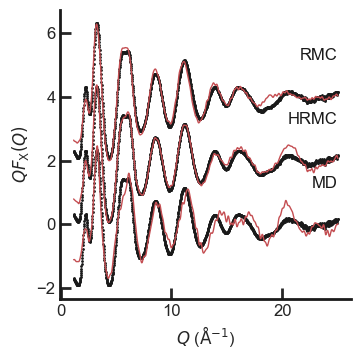

In [3]:
offset = 2.0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75,3.75))

plt.scatter(xray[:,0], xray[:,1]+offset*2, c='k', label="data", s=1)
plt.plot(rmc_xray[:,0], rmc_xray[:,1]+offset*2, c='r', label="RMC", lw=1)
plt.text(xray[-1,0], xray[-1,1]+offset*2+1.0, 'RMC', ha='right')

plt.scatter(xray[:,0], xray[:,1]+offset, c='k', label="data", s=1)
plt.plot(hrmc_xray[:,0], hrmc_xray[:,1]+offset, c='r', label="HRMC", lw=1)
plt.text(xray[-1,0], xray[-1,1]+offset+1.0, 'HRMC', ha='right')

plt.scatter(xray[:,0], xray[:,1], c='k', label="data", s=1)
plt.plot(md_xray[:,0], md_xray[:,1], c='r', label="MD", lw=1)
plt.text(xray[-1,0], xray[-1,1]+1.0, 'MD', ha='right')

ax.set_xlabel(r'$Q$ ($\rm \AA^{-1}$)')
ax.set_ylabel(r'$QF_{\rm X}(Q)$')
plt.savefig('figures/main/fig1a.pdf', dpi=600)
plt.show()

In [4]:
# relative energies/chi2.
hrmc_cost = np.load('simulations/hrmc/rdfs/intra/1500/costs.npy')
rmc_cost = np.load('simulations/rmc/rdfs/original/costs.npy')
md_cost = np.load('simulations/hrmc/molecular_dynamics/rdfs/costs.npy')

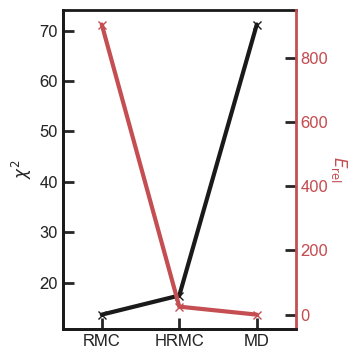

In [5]:
costs = np.vstack([rmc_cost, hrmc_cost, md_cost])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75,3.75))
ax2 = ax.twinx()

xval = np.arange(0, costs.shape[0])
ax.plot(xval, costs[:,1], c="k", marker="x")
ax2.plot(xval, ((costs[:,0]/1620) - np.amin(costs[:,0]/1620)) * 1.60217733e-22 * 6.0223e23, c="r", marker="x")

ax.set_xlim([-0.5,costs.shape[0]-0.5])
ax.set_xticks(range(costs.shape[0]))
ax.set_xticklabels(['RMC', 'HRMC', 'MD'])

ax.set_ylabel(r'$\chi^2$')
ax2.set_ylabel(r'$E_{\rm rel}$', rotation=270, labelpad=15, c="r")

for tl in ax2.get_yticklabels():
    tl.set_color('r')

ax.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('r')

plt.tight_layout()
plt.savefig('figures/main/fig1b.pdf', dpi=600)
plt.show()

In [6]:
headers = ['simulation', 'energy', 'chi2']
simulation_types = ['rmc', 'hrmc', 'md']
final_costs = costs.copy()
final_costs[:,0] = (final_costs[:,0]/1620) - np.amin(final_costs[:,0]/1620)
final_costs[:, 0] *= 1.60217733e-22 * 6.0223e23

data = {
    'simulation': simulation_types,
    'energy': final_costs[:,0],
    'chi2': final_costs[:,1]
}

df = pd.DataFrame(data)
df.to_csv('data/computed/costs.csv', index=False)

---
### Coordination environments in ACC

In [7]:
hrmc_data = retrieve_hrmc_data()
molecule_data = hrmc_data['molecules_data']

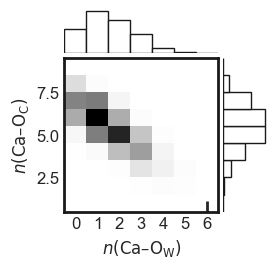

In [8]:
# calcium coordination.
ca_oc = np.array([i.carbonate_o_cn for i in molecule_data['ca']])
ca_ow = np.array([i.water_o_cn for i in molecule_data['ca']])

fig = plt.figure(figsize=(3.375,3.375))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7), 
        left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(ax, ax_histx, ax_histy, ca_ow, ca_oc)
ax.spines[['right', 'top']].set_visible(True)
ax.set_xlabel(r"$n({\rm Ca–O_W})$")
ax.set_ylabel(r"$n({\rm Ca–O_C})$")
plt.savefig('figures/main/fig2a.pdf', dpi=600)
plt.show()

In [9]:
data = {
    'O_C': ca_oc,
    'O_W': ca_ow,
}
df = pd.DataFrame(data)
df.to_csv('data/computed/ca_coordination_numbers.csv', index=False)

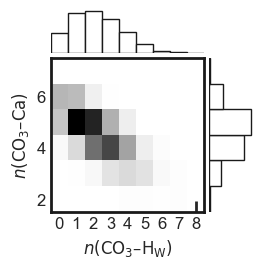

In [10]:
# carbonate coordination.
co3_ca = np.array([len(i._bound_ca) for i in molecule_data['co3']])
co3_h2o = np.array([len(i._bound_h2o) for i in  molecule_data['co3']])

fig = plt.figure(figsize=(3.375,3.375))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7), 
        left=0.2, right=0.8, bottom=0.2, top=0.8, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(ax, ax_histx, ax_histy, co3_h2o, co3_ca)
ax.spines[['right', 'top']].set_visible(True)
ax.set_xlabel(r"$n({\rm CO_3–H_W})$")
ax.set_ylabel(r"$n({\rm CO_3–Ca})$")
plt.savefig('figures/main/fig2b.pdf', dpi=600)
plt.show()

In [11]:
ca_pair_coorelations = pd.read_csv(
    'data/computed/ca_pair_correlations.csv',
)

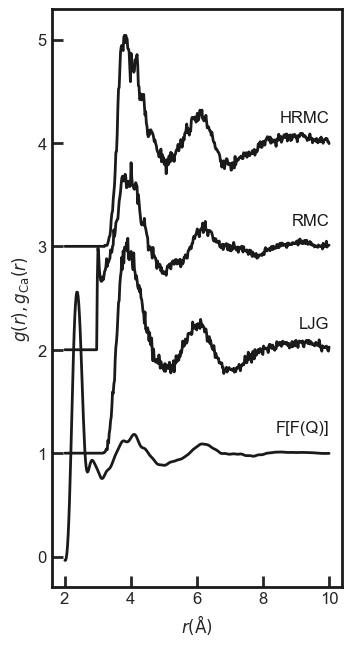

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75,7.5))

for i, name in enumerate(reversed(ca_pair_coorelations.columns.values[1:])):
    plt.plot(
        ca_pair_coorelations['r (A)'],
        ca_pair_coorelations[name] + i,
        label=name,
        c='k',
        lw=2
    )
    plt.text(10, i+1.25, name, fontsize=12, color='k', ha='right', va='center')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_xlabel(r'$r {\rm (\AA)}$', fontsize=12)
ax.set_ylabel(r'$g(r), g_{\rm Ca}(r)$', fontsize=12)
plt.savefig('figures/main/fig2e.pdf', dpi=600)
plt.show()

---
### Effective Ca–Ca interactions in ACC

In [13]:
effective_interaction_potential = pd.read_csv(
    'data/computed/effective_interaction_potential.csv'
)

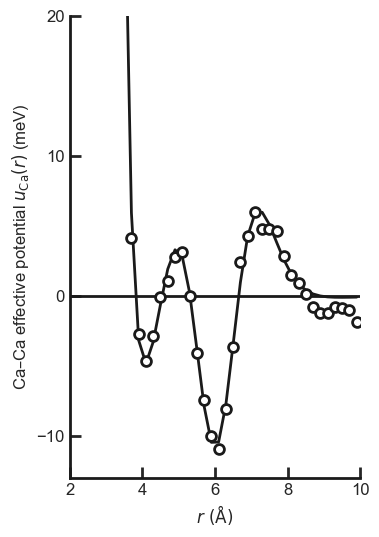

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75,6))

ax.plot(
    effective_interaction_potential['r (A)'],
    effective_interaction_potential['LJG fit'],
    c='k', lw=2
)

ax.scatter(
    effective_interaction_potential['r (A)'],
    effective_interaction_potential['UCa(r)'],
    marker='o',
    facecolors='w',
    edgecolors='k',
    linewidth=2,
    s=50,
    zorder=10
)

ax.hlines(0, 2, 10, color='k', lw=2,)

ax.set_xlim([2,10])
ax.set_ylim([-13, 20])
ax.set_yticks([-10, 0, 10, 20])

ax.set_xlabel(r'$r~{\rm (\AA)}$', fontsize=12)
ax.set_ylabel(r'Ca–Ca effective potential $u_{\rm Ca}(r)$ (meV)', fontsize=12)
plt.savefig('figures/main/fig3a.pdf', dpi=600)
plt.show()

In [15]:
# load in data (might have already been done in the notebook).
hrmc_data = retrieve_hrmc_data()
molecule_data = hrmc_data['molecules_data']

# set variables for the compute.
max_distance = 10.0
bin_width = 0.1

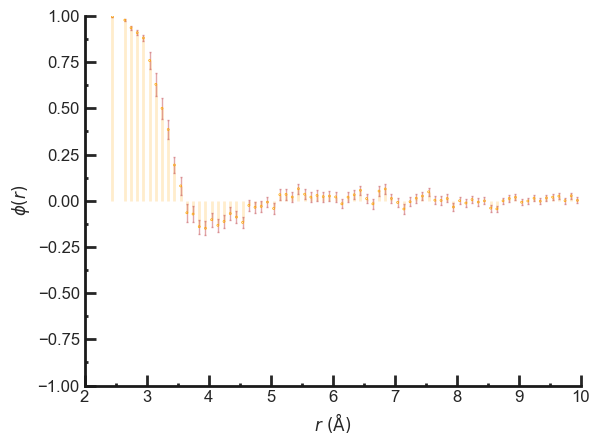

In [16]:
# compute the orientational correlation function.
co3_correlation = compute_orientational_correlation_function(
    molecule_data['co3'], 
    hrmc_data['lattice'], 
    carbonate_orientation,
    bin_width=bin_width,
    max_distance=max_distance
)

# plot.
fig, ax = plt.subplots()
co3_data = plot_orientational_correlation(ax, co3_correlation)
ax.set_xlim([2,10])
plt.savefig('figures/main/fig3a_inset_a.pdf', dpi=600)
plt.show()


# write data to file.
write_orientational_data(
    'data/computed/co3_orientational_correlation_function.csv',
    *co3_data
)

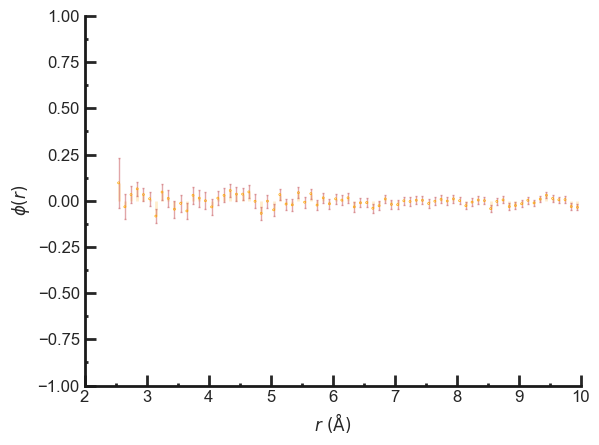

In [17]:
# compute the orientational correlation function.
h2o_correlation = compute_orientational_correlation_function(
    molecule_data['h2o'], 
    hrmc_data['lattice'], 
    water_orientation,
    molecule_coordinates_attribute='oxygen_cartesian_position',
    bin_width=bin_width,
    max_distance=max_distance
)

# plot.
fig, ax = plt.subplots()
h2o_data = plot_orientational_correlation(ax, h2o_correlation)
ax.set_xlim([2,10])
plt.savefig('figures/main/fig3a_inset_b.pdf', dpi=600)
plt.show()

# write data to file.
write_orientational_data(
    'data/computed/h2o_orientational_correlation_function.csv',
    *h2o_data
)